In [ ]:
cd bren-eds213-data/HW8
sqlite3 big-fat.sqlite3
.tables

In [ ]:
SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';

In [ ]:
SELECT CASE WHEN count(distinct Nest_ID)= count(Nest_ID)
THEN 'column values are unique' ELSE 'column values are NOT unique' END
FROM Bird_nests;

## Part 1
Answer the following questions.

*Is there already an index on the Bird_nests table? If so, what is that index and will SQLite use it in the above query? Why or why not?*

*Will adding an index on a column not mentioned in the WHERE clause be used by the database? Why or why not?*

**No, there is no index on the Bird_nests table. SQL uses the values index in the WHERE clause of the query as it is the primary key.**

**Adding an index on a column would not be used in the WHERE clause, as SQLite only uses indexes relevant to the specific query being executed.**

## Part 2

Query optimization, which falls under the general heading of “database tuning,” is a complex subject, as query performance depends on the query or queries being supported, the distribution and nature of the data, the abilities and characteristics of the query planner, and the costs of creating and maintaining indexes. Still, we can make a general observation about what makes for a good index (“good” meaning improving query performance here) by examining the effects of adding different indexes on the Bird_nests table and timing the above query.

### Your task is to conduct at least 15 experiments. In each experiment perform the following steps:

- Create an index on a column or columns.
- Time the above query. (To time a query, execute it many times in a loop, and divide the total time required by the number of repetitions to get the average query time. Be sure to use this approach, as query times can be highly variable.)
- Drop the index (to avoid accumulating indexes on the table).
- Also, determine the number of distinct values in the index, i.e., the number of distinct values in the column or number of distinct tuples if the index is over multiple columns.


### What experiments to run?

- Run an initial experiment with no added index. For this experiment only, record the number of distinct values as 1.
- Try adding an index on each column mentioned in the WHERE clause (e.g., Site): that’s 5 experiments right there.

- Try adding an index on a couple of columns at a time. Try at least the following combinations, but add others if you like:
``` 
Site,Species
Site,Observer
Species,Observer
Year,Observer
Observer,ageMethod
```
- Try adding an index on 3-4 columns at a time.
- When done, you will want your results in the form of a CSV file with three columns: label, average query time, and number of distinct values. If you use the label “none” for the initial experiment and the columns indexed as the label, your CSV file might resemble:

```
label,avg_query_time,num_distinct_values
none,#####,1
Site,#####,16
Species,#####,#####
Year,#####,#####
Observer,#####,#####
ageMethod,#####,#####
"Site,Species",#####,#####
"Site,Observer",#####,#####
...
```

For timing, you can use the Bash test harness you developed in week 5, or you can do your timings from R or Python if you prefer. Regardless of the language, ensure that you compute the average time it takes to perform the query as described above.

You can run your test harness manually for each experiment, and manually retrieve the number of distinct values for step 4 above. That’s just fine. But you can also automate the whole process; some hints for doing so are below. Be careful when running your test harness, as in the end you want just one row in your CSV file per experiment. Don’t get hung up on automating the experiments; that’s not a requirement.

Once you have your data, load it in Jupyter or RStudio and create a log-log scatter plot of the number of distinct index values (X axis) versus query time (Y axis). (Results will be difficult to see if both axes are not logarithmic.) If all goes well, your plot should resemble something like this:



Recall that num_distinct_values = 1, the leftmost point on your scatter plot, corresponds to using no index at all.

**Finally,**

Answer these questions:

*What relationship do you observe? Hypothesize why you see the relationship you do.*
*What conclusion do you draw regarding what makes a good index?*

Upload all your work: your test harness, your analysis notebook, and your CSV file.


#### Import Libraries

In [74]:
import sqlite3
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Connect to SQLite Database

In [67]:
conn = sqlite3.connect("big-fat.sqlite3")

#### Initialize Variables

In [68]:
QUERY = """
SELECT Nest_ID
FROM Bird_nests
WHERE Site = 'nome'
  AND Species = 'ruff'
  AND Year = 1983
  AND Observer = 'cbishop'
  AND ageMethod = 'float';
"""
repititions = 100

# Experiments: (label, list_of_columns)
indexes = [
    ("none", []),
    ("Site", ["Site"]),
    ("Species", ["Species"]),
    ("Year", ["Year"]),
    ("Observer", ["Observer"]),
    ("ageMethod", ["ageMethod"]),
    ("Site,Species", ["Site", "Species"]),
    ("Site,Observer", ["Site", "Observer"]),
    ("Site,Year", ["Site", "Year"]),
    ("Year,Species", ["Year", "Species"]),
    ("Species,Observer", ["Species", "Observer"]),
    ("Species,ageMethod", ["Species", "ageMethod"]),
    ("Year,Observer", ["Year", "Observer"]),
    ("Observer,ageMethod", ["Observer", "ageMethod"]),
    ("Observer,Year,Species", ["Observer", "Year", "Species"]),
]


#### Run Timing Test

In [ ]:

results = []

for label, col_list in indexes:
    
     # Create index variable name based on columns
    if len(col_list) > 0:
        index_name = f"index_{'_'.join(col_list)}"
    else:
        index_name = None

    # Drop the index if it exists in database
    if index_name!= None:
        conn.execute(f"DROP INDEX IF EXISTS {index_name}")

    # Create index in database
    if len(col_list) > 0:
        col_list_str = ", ".join(col_list)
        conn.execute(f"CREATE INDEX {index_name} ON Bird_nests ({col_list_str})")

    # Test harness
    start_time = time.time()
    for _ in range(repititions):
        conn.execute(QUERY).fetchall()
    end_time = time.time()
    avg_time = (end_time - start_time) / repititions

    # Count distinct values
    if len(col_list) == 0:
        distinct_count = 1
    elif len(col_list) == 1:
        distinct_count = conn.execute(f"SELECT COUNT(DISTINCT {col_list[0]}) FROM Bird_nests").fetchone()[0]
    else:
        distinct_col_list = ", ".join(col_list)
        distinct_count = conn.execute(f"SELECT COUNT(*) FROM (SELECT DISTINCT {distinct_col_list} FROM Bird_nests)").fetchone()[0]


    results.append((label, avg_time, distinct_count))


#### Close Connection

In [70]:

conn.close()


#### Create DataFrame and Save to CSV

In [76]:

# Save and display
timings_df = pd.DataFrame(results, columns=["label", "avg_query_time", "num_distinct_values"])
#timings_df.to_csv("timings.csv", index=False)
timings_df = pd.read_csv("timings.csv") 
timings_df

,label,avg_query_time,num_distinct_values
0,none,2.466912,1
1,Site,0.227327,16
2,Species,0.047863,99
3,Year,0.065507,66
4,Observer,0.019666,269
5,ageMethod,1.026375,3
6,"Site,Species",0.003486,1584
7,"Site,Observer",0.001020,4304
8,"Site,Year",0.004384,1056
9,"Year,Species",0.000648,6534


#### Plot Results

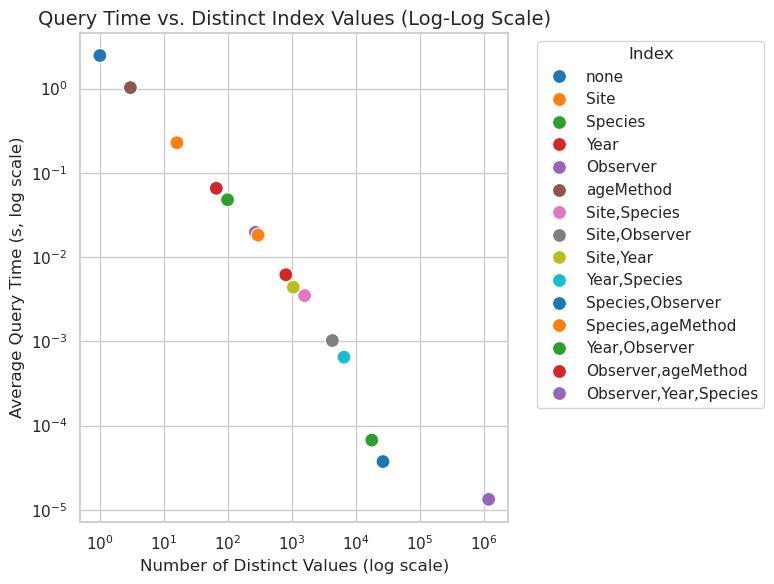

In [77]:

# Set up the figure and style
sns.set_theme(style="whitegrid", context="notebook")

# Create the plot
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(
    data=timings_df,
    x="num_distinct_values",
    y="avg_query_time",
    hue="label",  # Optional: helps identify the indexed columns
    palette="tab10",
    s=100  # point size
)

# Set log scale
plot.set(xscale="log", yscale="log")

# Add axis labels and title
plot.set_title("Query Time vs. Distinct Index Values (Log-Log Scale)", fontsize=14)
plot.set_xlabel("Number of Distinct Values (log scale)", fontsize=12)
plot.set_ylabel("Average Query Time (s, log scale)", fontsize=12)

# Improve layout
plt.legend(title="Index", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


*What relationship do you observe? Hypothesize why you see the relationship you do.*

**There is a near linear relationship between the number of distinct values in the index and the average query time on this log-log plot. This means that the average query time decreases exponentially as the number of distinct values in the index increases. This is likely because a larger number of distinct values allows the database to more efficiently narrow down the search space for the query, leading to faster retrieval times.**

What conclusion do you draw regarding what makes a good index?

**A good index is one that has the most possible distinct values, allowing the system to parse as little data as possible. With efficiency increased, the query is excecuted much faster.**